<a href="https://colab.research.google.com/github/JurijJusel/Image/blob/t13-kernel-effects/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [28]:
import time
from time import gmtime
from time import strftime

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data


In [ ]:
augmented_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/train/'
validate_data_path = '/content/drive/MyDrive/Colab Notebooks/Image/data/augmented/validate/'

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(augmented_data_path)
validate_data = tf.keras.utils.image_dataset_from_directory(validate_data_path)

Found 3567 files belonging to 2 classes.
Found 603 files belonging to 2 classes.


In [ ]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1].shape

(32,)

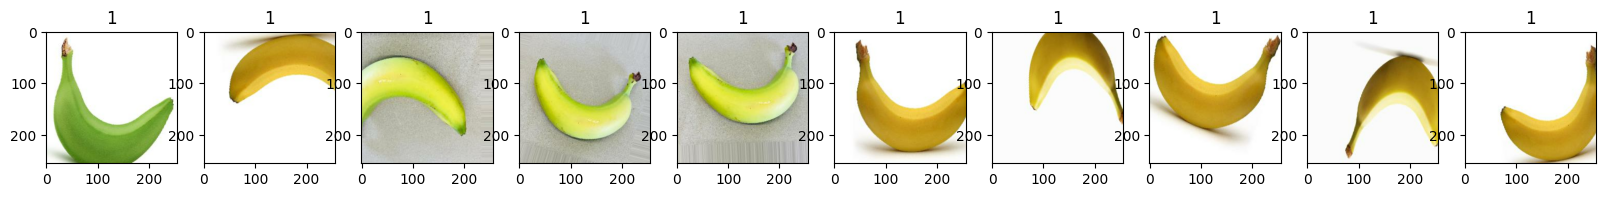

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Proportion of dataset

In [ ]:
def class_balance(dataset):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)

    for images, labels in dataset:
        for label in labels:
            class_counts[label] += 1

    total_images = sum(class_counts)
    percentages = [count/total_images*100 for count in class_counts]
  
    for name, count, percentage in zip(class_names, class_counts, percentages):
        print(f"Class {name} - {count} images - {percentage:.2f}% of {total_images}")

    if 1 >= min(percentages) / max(percentages) >= 0.8:
        print("This dataset is balanced")
    else:
        print("This dataset is imbalanced")

In [ ]:
class_balance(data)

[50.08291873963516, 49.917081260364846]
Class apple - 302 images - 50.08% of 603
Class banana - 301 images - 49.92% of 603
49.917081260364846
50.08291873963516
This dataset is balanced


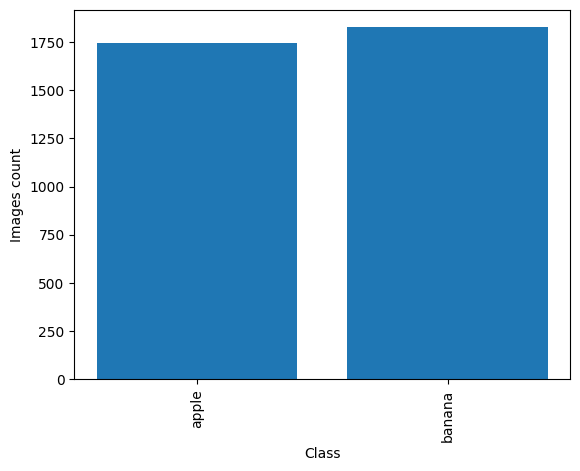

In [ ]:
figure, axes = plt.subplots()
axes.bar(['apple', 'banana'], [1742, 1825])

axes.set_xlabel('Class')
axes.set_ylabel('Images count')
axes.set_xticks(['apple', 'banana'])
axes.set_xticklabels(['apple', 'banana'], rotation=90)

plt.show()


# Data preprocessing

In [ ]:
# Scale Data
data_scale = data.map(lambda x, y:(x/255, y))
validate_data_scale=validate_data.map(lambda x, y:(x/255, y))


In [ ]:
len(data_scale)

112

In [ ]:
train_size = int(len(data_scale)*0.7)
val_size = int(len(data_scale)*0.2)
test_size = int(len(data_scale)*0.1)+1

In [ ]:
train_size

78

In [ ]:
val_size

22

In [ ]:
test_size

12

In [ ]:
train = data_scale.take(train_size)
val = data_scale.skip(train_size).take(val_size)
test = data_scale.skip(train_size+val_size).take(test_size)

In [ ]:
scaled_iterator = data_scale.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].min()

0.0

In [ ]:
batch[0].max()

1.0

In [ ]:
batch[0].shape

(32, 256, 256, 3)

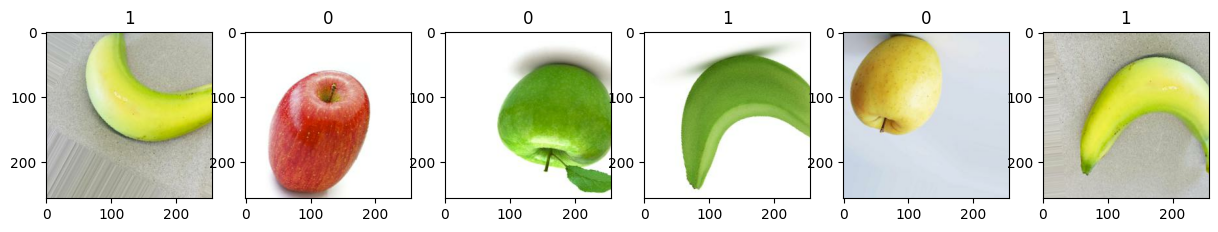

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(15,15))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Build Deep Learning model

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 60, 60, 128)       36992     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 30, 30, 128)    

# Train and save model

In [ ]:
def amount_time(func):
    def stopwatch_timer():
        start_time = time.perf_counter()
        trained_model = func()
        model.save('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_1.h5')
        stop_time = time.perf_counter()
        duration = stop_time - start_time
        durat_str = strftime("%Hh:%Mm:%Ss", gmtime(duration))
        print(durat_str)
        return trained_model
    return stopwatch_timer

In [ ]:
@amount_time
def train_model():
    return model.fit(data_scale, steps_per_epoch=10, epochs=10, validation_data=validate_data_scale, validation_steps=10, shuffle=True)

In [ ]:
trained_model=train_model()

Epoch 1/10
10/10 [==============================] - 44s 4s/step - loss: 1.5850 - accuracy: 0.5656 - val_loss: 0.4064 - val_accuracy: 0.8094
Epoch 2/10
10/10 [==============================] - 51s 5s/step - loss: 0.3787 - accuracy: 0.8406 - val_loss: 0.3274 - val_accuracy: 0.8125
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.2710 - accuracy: 0.8719 - val_loss: 0.1582 - val_accuracy: 0.9406
Epoch 4/10
10/10 [==============================] - 42s 4s/step - loss: 0.1889 - accuracy: 0.9312 - val_loss: 0.2514 - val_accuracy: 0.8875
Epoch 5/10
10/10 [==============================] - 42s 4s/step - loss: 0.2047 - accuracy: 0.9031 - val_loss: 0.1442 - val_accuracy: 0.9406
Epoch 6/10
10/10 [==============================] - 42s 4s/step - loss: 0.1753 - accuracy: 0.9281 - val_loss: 0.0961 - val_accuracy: 0.9750
Epoch 7/10
10/10 [==============================] - 41s 4s/step - loss: 0.1102 - accuracy: 0.9469 - val_loss: 0.0633 - val_accuracy: 0.9750
Epoch 8/10
10/10 [==

In [ ]:
trained_model.history

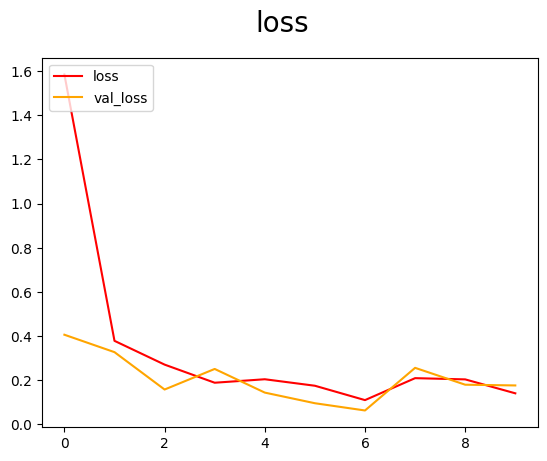

In [ ]:
#Plot Performance
fig=plt.figure()
plt.plot(trained_model.history['loss'], color='red', label='loss')
plt.plot(trained_model.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

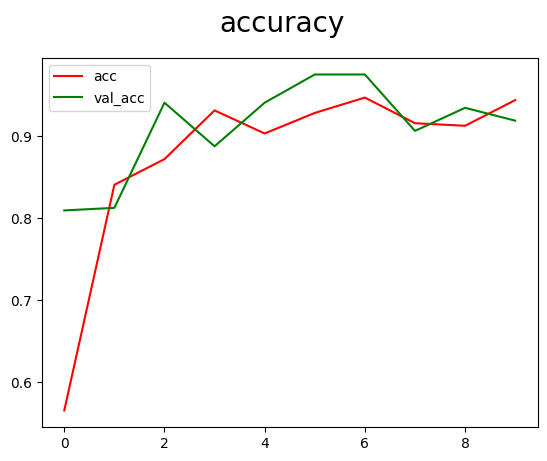

In [ ]:
fig=plt.figure()
plt.plot(trained_model.history['accuracy'], color='red', label='acc')
plt.plot(trained_model.history['val_accuracy'], color='green', label='val_acc')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Perfomance

In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model_new.h5')

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in validate_data.as_numpy_iterator():
    X, y = batch
    model_predict = new_model.predict(X)
    pre.update_state(y, model_predict)
    re.update_state(y, model_predict)
    acc.update_state(y, model_predict)

1/1 [==============================] - 3s 3s/step


In [ ]:
pre.result().numpy()

0.9735099

In [ ]:
re.result().numpy()

0.9767442

In [ ]:
acc.result().numpy()

0.97512436

# Test image

In [ ]:
user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_68.jpg'  # apple
# user_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/banana/Image_96.jpg'  # banana

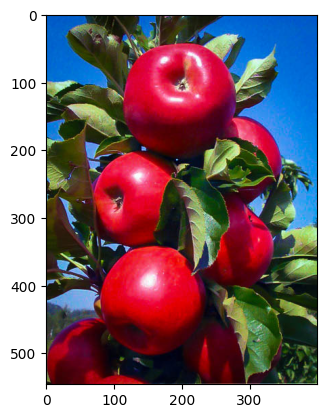

In [ ]:
img_read = cv2.imread(user_image)
plt.imshow(cv2.cvtColor(img_read,cv2.COLOR_BGR2RGB))
plt.show()
# img_path

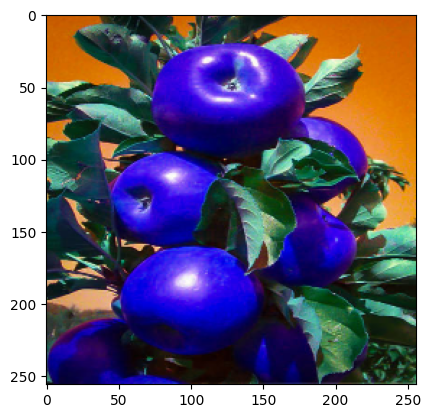

In [ ]:
img_resize = cv2.resize(img_read, (256, 256))
plt.imshow(img_resize)
plt.show()

In [ ]:
# np_exp= np.expand_dims(img_resize,0).shape

In [ ]:
img_array = np.array(img_resize) / 255.0  # normalize pixel values
img_expanded = np.expand_dims(img_array, axis=0)  # expand dimensions to match input shape


# Predict test image


In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model.h5')

In [ ]:
predictions = new_model.predict(img_expanded, batch_size=10, verbose=0)
predictions

array([[1.5390009e-07]], dtype=float32)

# Confusion matrix

In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/Image/models/cnn_model.h5')

In [ ]:
data_iterator = validate_data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
batch_image = batch[0]
batch_labels = batch[1]

In [ ]:
batch[0].shape, batch[1].shape

((32, 256, 256, 3), (32,))

In [ ]:
y_pred = new_model.predict(batch_image)

1/1 [==============================] - 1s 820ms/step


In [ ]:
cm = confusion_matrix(batch_labels, y_pred)
cm

array([[19,  0],
       [ 0, 13]])

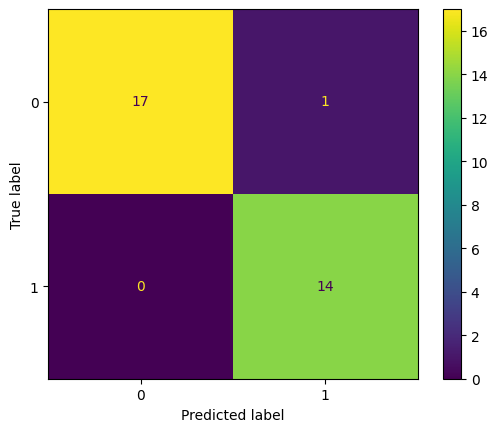

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

Confusion matrix from validate dataset

In [ ]:
test_data = np.concatenate([x for x, y in validate_data], axis=0)
test_label = np.concatenate([y for x, y in validate_data], axis=0)

In [ ]:
y_pred = new_model.predict(test_data).astype(int)

19/19 [==============================] - 16s 853ms/step


In [ ]:
cm = confusion_matrix(test_label, y_pred)
cm

array([[153, 149],
       [153, 148]])

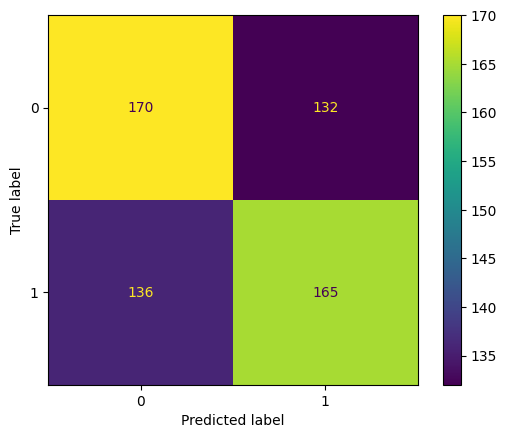

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

# Kernel

In [3]:
test_image='/content/drive/MyDrive/Colab Notebooks/Image/dataset/apple/Image_56.jpg'  # apple

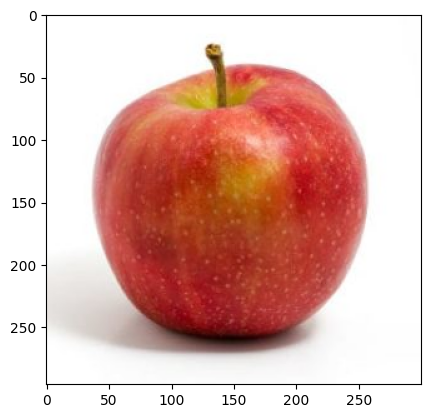

In [120]:
img_read = cv2.imread(test_image)
plt.imshow(cv2.cvtColor(img_read,cv2.COLOR_BGR2RGB))
plt.show()
# img_path

In [ ]:
# filter2D

In [71]:
blur_filter = np.array([
    [1,1,1],
    [1,1,1],
    [1,1,1],
])
blur_filter =blur_filter / 6

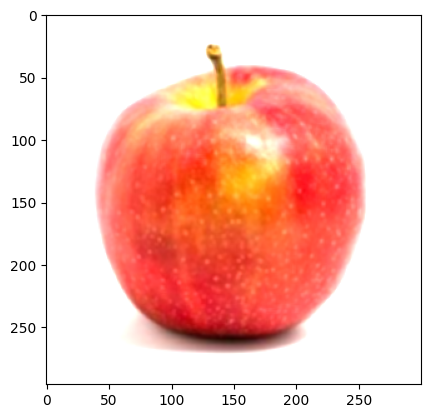

In [72]:
blurred_img = cv2.filter2D(img_read, ddepth=-1, kernel=blur_filter)
plt.imshow(cv2.cvtColor(blurred_img,cv2.COLOR_BGR2RGB))

In [ ]:
# no filter

In [88]:
no_filter = np.array([
    [0,0,0],
    [0,1,0],
    [0,0,0],
])
# no_filter = no_filter * 3

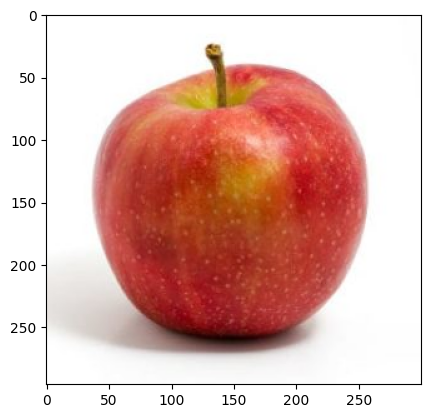

In [89]:
img = cv2.filter2D(img_read, ddepth=-1, kernel=no_filter)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


In [125]:
# blur
blur_img = cv2.blur(img_read, ksize=(15,15))

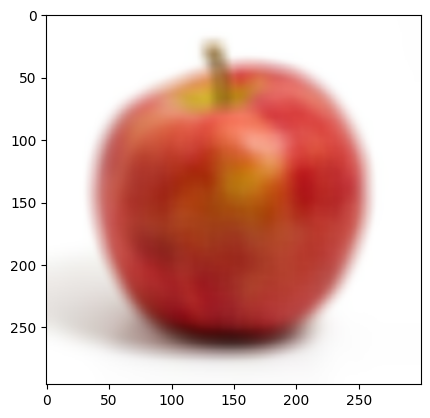

In [126]:
img = cv2.filter2D(blur_img, ddepth=-1, kernel=no_filter)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


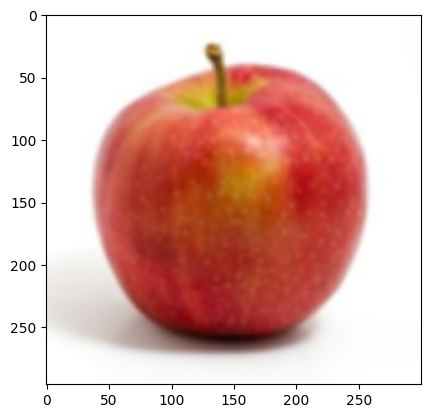

In [148]:
gaus_img = cv2.GaussianBlur(img_read, ksize=(5,5), sigmaX=300, sigmaY=300)
plt.imshow(cv2.cvtColor(gaus_img,cv2.COLOR_BGR2RGB))

In [172]:
#sharpen
sharpen_filter = np.array([
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0],
])

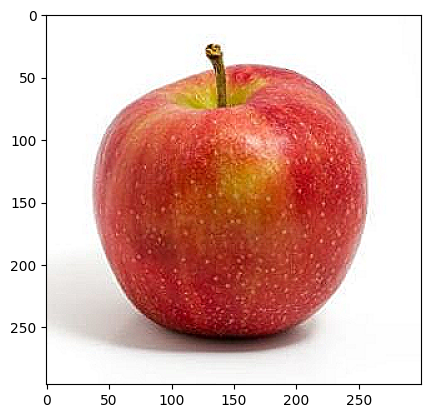

In [173]:
img = cv2.filter2D(img_read, ddepth=-1, kernel=sharpen_filter)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
# edge detection

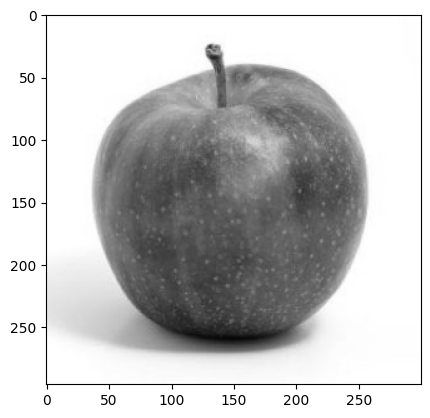

In [177]:
gray_img = cv2.cvtColor(img_read,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray_img,cv2.COLOR_BGR2RGB))